In [22]:
# =============================================================================
# 필수 라이브러리 임포트
# =============================================================================
import cv2              # OpenCV: 이미지 처리 (읽기, 변환, 필터링 등)
import numpy as np      # NumPy: 수치 연산 및 배열 처리
import matplotlib.pyplot as plt  # Matplotlib: 결과 시각화 및 그래프 출력

In [23]:
# =============================================================================
# 족저압(Plantar Pressure) 히트맵 생성 함수
# =============================================================================
# [목적] 카메라로 촬영된 발바닥 이미지 → (1) 가상 압력맵 (2) UI용 히트맵 생성
# [처리 흐름] 이미지 로드 → 배경 제거 → 포화 보정 → Gamma 변환 → 스무딩 → 정규화 → 히트맵
#
# [핵심 배경지식: 피부의 비선형 탄성]
# - 선형 탄성체(스프링): F = kx (힘 2배 → 변형 2배)
# - 비선형 탄성체(피부): P ∝ I^γ (압력 2배 → 변형 4배 이상)
# - 피부는 다층 구조(표피, 진피, 지방층)로 압력이 커질수록 더 많이 눌림
# - 따라서 이미지 밝기(변형량)와 실제 압력은 비선형 관계
# =============================================================================

def generate_advanced_pressure_map(image_path, user_weight_kg=70.0, gamma=2.0):  
    """
    발바닥 이미지 → 물리적 특성이 고려된 Pressure Map 생성
    
    Parameters:
        image_path (str): 입력 이미지 경로
        user_weight_kg (float): 사용자 체중 (kg) - 총 힘 정규화용
        gamma (float): 비선형 보정 계수 (P ∝ I^γ, 기본값 2.0)
    
    Returns:
        linear_pressure_map (ndarray): 선형 압력맵 - 분석/딥러닝용 (권장)
        gamma_pressure_map (ndarray): Gamma 압력맵 - 참고용 (캘리브레이션 필요)
        heatmap (ndarray): 컬러 히트맵 - UI/시각화용 (BGR, 발 부분만 표시)
        foot_mask (ndarray): 발 영역 마스크 (시각화용)
    """
    
    # =========================================================================
    # STEP 1: 이미지 로드 및 그레이스케일 변환
    # =========================================================================
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("이미지를 찾을 수 없습니다.")
        return None, None, None, None
    
    # 그레이스케일 변환: 밝기(0~255) = 압력의 원시 데이터
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # =========================================================================
    # STEP 2: 배경 제거 (Otsu 이진화)
    # =========================================================================
    # Otsu: 자동으로 최적 임계값을 찾아 전경(발)/배경 분리
    _, foot_mask = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # =========================================================================
    # STEP 3: 포화(Saturation) 영역 보정
    # =========================================================================
    # 문제: 고압력 영역(뼈 돌출부)에서 255로 클리핑 → 정점 손실
    # 해결: Distance Transform으로 포화 영역에 "산봉우리" 복원
    saturation_mask = cv2.threshold(img_gray, 250, 255, cv2.THRESH_BINARY)[1]
    
    # 0~1 범위로 정규화
    pressure_map = img_gray.astype(np.float32) / 255.0
    pressure_map[foot_mask == 0] = 0  # 배경 제거
    
    # 포화 영역 보정 (존재하는 경우에만)
    if cv2.countNonZero(saturation_mask) > 0:
        dist_transform = cv2.distanceTransform(saturation_mask, cv2.DIST_L2, 5)
        dist_norm = cv2.normalize(dist_transform, None, 0, 1.0, cv2.NORM_MINMAX)
        pressure_map[saturation_mask > 0] += (dist_norm[saturation_mask > 0] * 0.3)

    # =========================================================================
    # STEP 4: 선형 데이터 백업 + Gamma 변환
    # =========================================================================
    # [Gamma 보정 이유]
    # - 문제: 밝기(변형량)와 압력은 비선형 관계 → 선형 가정 시 저압력 과대평가, 고압력 과소평가
    # - 해결: Gamma 변환 (압력 = 밝기^γ, γ ≈ 2.0)
    # - 효과: 저압력(노이즈) 억제, 고압력 영역 강조
    # - 주의: γ값은 캘리브레이션 필요, 없으면 선형 압력맵 사용 권장
    linear_pressure_map = pressure_map.copy()  # 선형: 분석/딥러닝용 (권장)
    pressure_map = np.power(pressure_map, gamma)  # Gamma: 참고용

    # =========================================================================
    # STEP 5: Gaussian Blur (공간적 스무딩)
    # =========================================================================
    # 지방 패드의 압력 분산 효과 모사 + 노이즈 감소
    pressure_map = cv2.GaussianBlur(pressure_map, (15, 15), 0)
    linear_pressure_map = cv2.GaussianBlur(linear_pressure_map, (15, 15), 0)

    # =========================================================================
    # STEP 6: 총 힘 정규화 (∑압력 = 체중)
    # =========================================================================
    # 선형 압력맵 정규화 (주 분석용)
    linear_total = np.sum(linear_pressure_map)
    if linear_total > 0:
        linear_pressure_map_normalized = linear_pressure_map * (user_weight_kg / linear_total)
    else:
        linear_pressure_map_normalized = linear_pressure_map
    
    # Gamma 압력맵 정규화 (참고용)
    gamma_total = np.sum(pressure_map)
    if gamma_total > 0:
        gamma_pressure_map = pressure_map * (user_weight_kg / gamma_total)
    else:
        gamma_pressure_map = pressure_map

    # =========================================================================
    # STEP 7: 컬러 히트맵 생성 (UI/시각화용) - 발 부분만 표시
    # =========================================================================
    # 선형 데이터 기반 (직관적), JET 컬러맵: 파랑(저압) → 빨강(고압)
    display_norm = cv2.normalize(linear_pressure_map_normalized, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = cv2.applyColorMap(display_norm.astype(np.uint8), cv2.COLORMAP_JET)
    
    # 발 마스크를 3채널로 변환하여 히트맵에 적용 (배경은 검은색으로)
    foot_mask_3ch = cv2.cvtColor(foot_mask, cv2.COLOR_GRAY2BGR) / 255.0
    heatmap = (heatmap * foot_mask_3ch).astype(np.uint8)

    return linear_pressure_map_normalized, gamma_pressure_map, heatmap, foot_mask

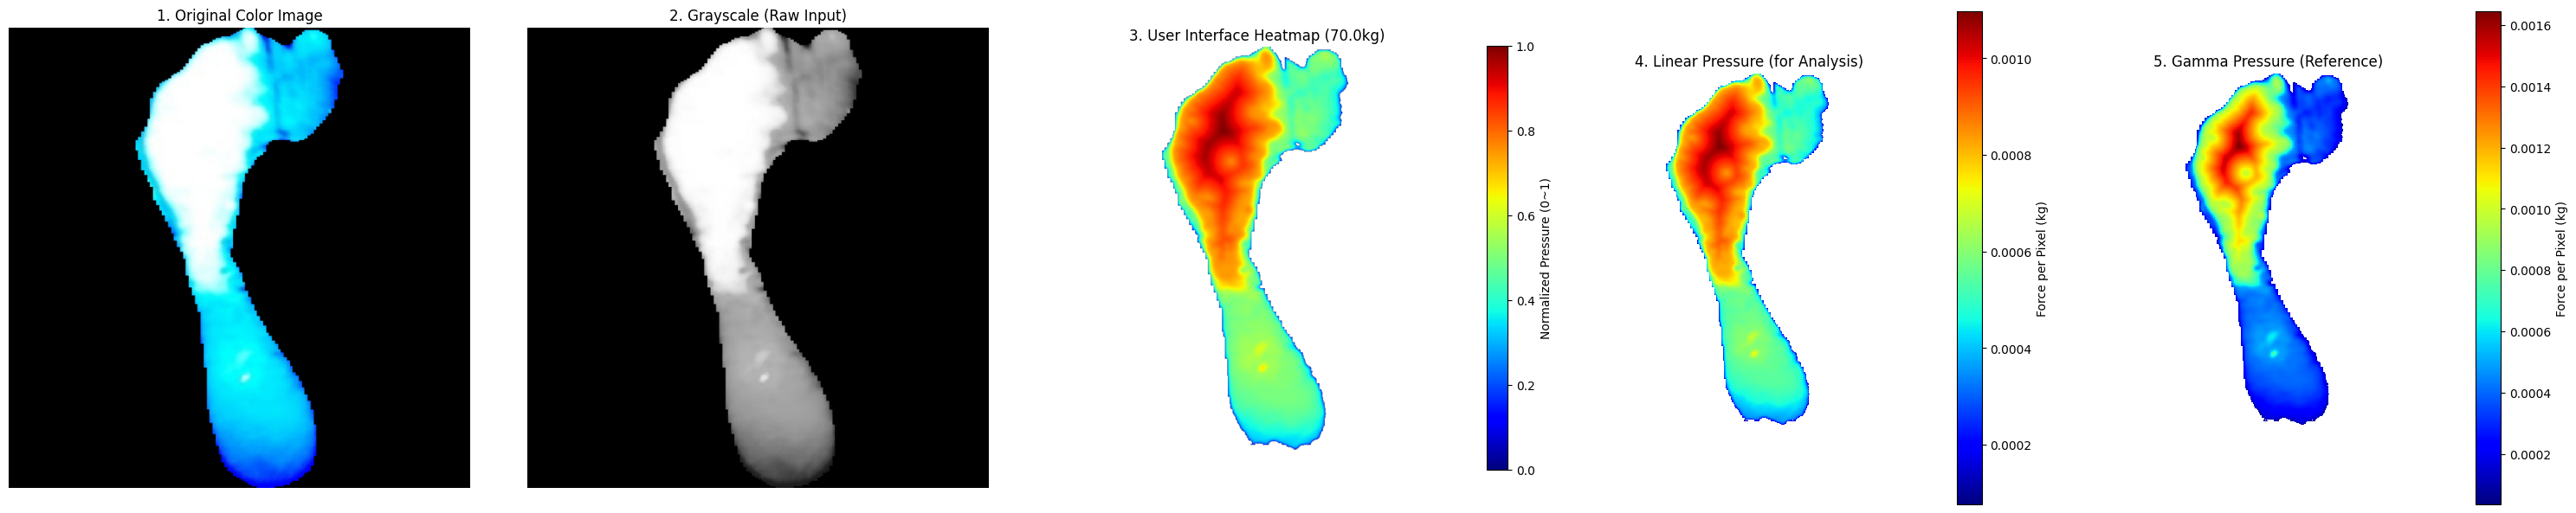

[선형] 총 압력: 70.00 kg (목표: 70.0 kg) ← 분석용
[Gamma] 총 압력: 70.00 kg (목표: 70.0 kg) ← 참고용


In [24]:
# =============================================================================
# 실행 및 결과 시각화
# =============================================================================
# [출력 구성]
# - 패널 1~2: 원본 이미지 (컬러, 그레이스케일)
# - 패널 3: UI용 히트맵 (보여주기용)
# - 패널 4: 선형 압력맵 (분석/딥러닝용, 권장)
# - 패널 5: Gamma 압력맵 (참고용)
# =============================================================================

# 입력 설정
input_image = './20260106/film_off_light_off_1/resize_film_off_light_off_1_04_balanced.jpg_left_720.png'
user_weight = 70.0  # kg

# 원본 이미지 로드
original_img_bgr = cv2.imread(input_image)
original_img_gray = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2GRAY) if original_img_bgr is not None else None

# 압력맵 생성 함수 실행
linear_pressure, gamma_pressure, heatmap_img, foot_mask = generate_advanced_pressure_map(input_image, user_weight)

# 결과 시각화 (5개 패널)
if linear_pressure is not None and original_img_gray is not None:
    plt.figure(figsize=(30, 6))
    
    # 패널 1: 원본 컬러 이미지
    plt.subplot(1, 5, 1)
    plt.title("1. Original Color Image")
    plt.imshow(cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    # 패널 2: 그레이스케일 (입력 데이터)
    plt.subplot(1, 5, 2)
    plt.title("2. Grayscale (Raw Input)")
    plt.imshow(original_img_gray, cmap='gray')
    plt.axis('off')
    
    # 패널 3: UI용 히트맵 (보여주기용) - 정규화된 히트맵, 배경 투명 (패널 4, 5와 동일한 방식)
    ax3 = plt.subplot(1, 5, 3)
    plt.title(f"3. User Interface Heatmap ({user_weight}kg)")
    # 압력맵을 0~1 범위로 정규화 (시각화용)
    normalized_heatmap = cv2.normalize(linear_pressure, None, 0, 1, cv2.NORM_MINMAX)
    # 발 마스크를 적용하여 배경은 투명하게 처리 (imshow는 마스킹된 배열을 자동으로 처리)
    masked_heatmap = np.ma.masked_where(foot_mask == 0, normalized_heatmap)
    im3 = plt.imshow(masked_heatmap, cmap='jet', origin='upper', interpolation='bilinear', vmin=0, vmax=1)
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='Normalized Pressure (0~1)')
    plt.axis('off')

    # 패널 4: 선형 압력맵 (분석/딥러닝용) - 권장 (발 부분만 표시, 배경 투명)
    # [Colorbar 수치 의미] 각 픽셀이 받는 힘(kg)
    # - 모든 픽셀 값의 합 = 사용자 체중 (예: 70kg)
    # - 값이 클수록 해당 픽셀에 더 많은 압력이 집중됨
    plt.subplot(1, 5, 4)
    plt.title("4. Linear Pressure (for Analysis)")
    # 발 마스크를 적용하여 배경은 투명하게 처리 (imshow는 마스킹된 배열을 자동으로 처리)
    masked_linear = np.ma.masked_where(foot_mask == 0, linear_pressure)
    im4 = plt.imshow(masked_linear, cmap='jet', origin='upper', interpolation='nearest')
    plt.colorbar(im4, label='Force per Pixel (kg)')
    plt.axis('off')

    # 패널 5: Gamma 압력맵 (참고용, 캘리브레이션 필요) (발 부분만 표시, 배경 투명)
    # [Colorbar 수치 의미] Gamma 보정된 각 픽셀의 힘(kg)
    # - Gamma 변환(P ∝ I^γ)으로 고압력 영역이 더 강조됨
    # - 선형 대비: 고압력 영역 값 ↑, 저압력 영역 값 ↓
    # - 총합은 동일하게 체중으로 정규화됨
    plt.subplot(1, 5, 5)
    plt.title("5. Gamma Pressure (Reference)")
    # 발 마스크를 적용하여 배경은 투명하게 처리 (imshow는 마스킹된 배열을 자동으로 처리)
    masked_gamma = np.ma.masked_where(foot_mask == 0, gamma_pressure)
    im5 = plt.imshow(masked_gamma, cmap='jet', origin='upper', interpolation='nearest')
    plt.colorbar(im5, label='Force per Pixel (kg)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 검증: 총 압력 합 = 체중
    print(f"[선형] 총 압력: {np.sum(linear_pressure):.2f} kg (목표: {user_weight} kg) ← 분석용")
    print(f"[Gamma] 총 압력: {np.sum(gamma_pressure):.2f} kg (목표: {user_weight} kg) ← 참고용")